In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# !pip install yfinance --upgrade --no-cache-dir
import pandas
from collections import deque
import random

In [10]:
df = pd.read_csv('Data\stock_data_TRV.csv')

In [11]:
df=df.iloc[::-1]

In [12]:
df.reset_index(inplace=True)

<AxesSubplot:>

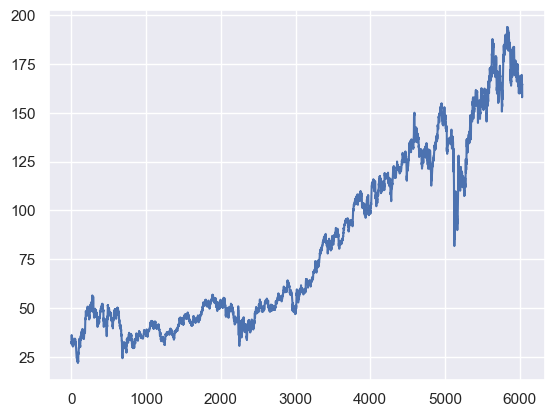

In [13]:
df['TRV_close'].plot()

In [14]:
close = df.TRV_close.values.tolist()

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import random
from collections import deque
tf.keras.utils.disable_interactive_logging()
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=100)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.model = self._build_model()
    def _build_model(self):
        model = Sequential()
        # model.add(LSTM(50, activation='relu', input_shape=(self.window_size, self.state_size)))
        # model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size))

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    # def _build_model(self):
    #     model = tf.keras.Sequential([
    #         tf.keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(self.state_size,)),
    #         tf.keras.layers.Dense(512, activation=tf.nn.relu),
    #         tf.keras.layers.Dense(self.action_size)
    #     ])

    #     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #     model.compile(loss='mean_squared_error', optimizer=optimizer)
    #     return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.model.predict(state)[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d: t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0: t + 1]
        res = [block[i + 1] - block[i] for i in range(window_size - 1)]
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        X = np.empty((batch_size, self.state_size))
        Y = np.empty((batch_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model.predict(states,verbose =None)
        Q_new = self.model.predict(new_states,verbose=None)
        for i in range(batch_size):
            print(i,'batch size')
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train_on_batch(X, Y)
        # with tf.GradientTape() as tape:
        #     pred = self.model(X)
        #     loss = 0.5 * tf.reduce_mean(tf.square(Y - pred))

        # gradients = tape.gradient(loss, self.model.trainable_variables)
        # self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost#loss.numpy()

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def plotmat(self, states_buy, states_sell):
        fig, ax = plt.subplots(figsize=(20, 10))

        ax.plot(self.trend, label='True Trend', linewidth=2.0)

        ax.scatter(states_buy, [self.trend[i] for i in states_buy], color='g', marker='^', label='Buy Signal')
        ax.scatter(states_sell, [self.trend[i] for i in states_sell], color='r', marker='v', label='Sell Signal')

        ax.legend()
        plt.show()
    def plotply(self, states_buy, states_sell):
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=list(range(len(self.trend))), y=self.trend, mode='lines', name='True Trend'))

        fig.add_trace(go.Scatter(x=states_buy, y=[self.trend[i] for i in states_buy],
                                 mode='markers', marker=dict(color='green', symbol='triangle-up'), name='Buy Signal'))

        fig.add_trace(go.Scatter(x=states_sell, y=[self.trend[i] for i in states_sell],
                                 mode='markers', marker=dict(color='red', symbol='triangle-down'), name='Sell Signal'))

        fig.update_layout(title='Trend and Trading Signals',
                          xaxis_title='Day',
                          yaxis_title='Price',
                          showlegend=True)

        fig.show()

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            print(i)
            total_profit = 0
            inventory = []
            states_buy = []  # Added line
            states_sell = []  # Added line
    
            state = self.get_state(0)
            starting_money = initial_money
    
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
    
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                    states_buy.append(t)  # Added line
    
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    states_sell.append(t)  # Added line
    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                print('replay')
                cost = self.replay(batch_size)
    
            if (i + 1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f' % (
                    i + 1, total_profit, cost, starting_money))
                self.plotply(states_buy, states_sell)  # Updated line
    

In [16]:

initial_money = 10000
window_size = 30
skip = 0
batch_size = 2
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 10, checkpoint = 1, initial_money = initial_money)

0
replay
0 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1 batch size
replay
0 batch size
1

KeyboardInterrupt: 